# Bitcoin Linear Regression: LR Analysis
2 February 2018

This notebook assembles the LR model fromt the DataFrame pickle file generated in the DataFrame notebook.  

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%matplotlib inline

import warnings; warnings.simplefilter('ignore')
import json
import time
import sys
import re
import datetime

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# import the pickled dataframe from BTC_DF
df = pd.read_pickle('data/benson_btcsentiment_df.pkl')
df = df[['BTCPrice','logBTCPrice','logETHPrice','logBTCVol','logTxFees','logCostperTxn','logNoTxns','logAvgBlkSz','logUniqueAddresses','logHashRate','logCrypto Market Cap','logNasdaq','logGold','logInterest','Interest','TxFees','Nasdaq']]
df_all = df
df_hist = df
df.head(2)


,BTCPrice,logBTCPrice,logETHPrice,logBTCVol,logTxFees,logCostperTxn,logNoTxns,logAvgBlkSz,logUniqueAddresses,logHashRate,logCrypto Market Cap,logNasdaq,logGold,logInterest,Interest,TxFees,Nasdaq
2016-07-13,656.669626,6.487181,2.356126,13.677656,10.454313,1.738710,12.296982,-0.261365,12.847761,14.232219,23.229166,8.518339,5.425787,1.098612,3.0,34693.7,5005.73
2016-07-14,656.132060,6.486362,2.350422,13.679501,10.469753,1.621366,12.292677,-0.210721,12.813804,14.136909,23.229166,8.523982,5.424421,1.098612,3.0,35233.5,5034.06


In [3]:
df.tail(2)

,BTCPrice,logBTCPrice,logETHPrice,logBTCVol,logTxFees,logCostperTxn,logNoTxns,logAvgBlkSz,logUniqueAddresses,logHashRate,logCrypto Market Cap,logNasdaq,logGold,logInterest,Interest,TxFees,Nasdaq
2018-01-30,10078.060655,9.218116,7.047987,13.010563,14.306699,4.568323,12.355251,0.018011,13.185582,16.767873,27.084168,8.909570,5.188670,3.401197,30.0,1.634257e+06,7402.48
2018-01-31,10226.021308,9.232691,6.981842,12.837952,14.305632,4.572123,12.374164,-0.012570,13.183346,16.888655,27.084168,8.910785,5.199436,3.401197,30.0,1.632514e+06,7411.48


In [4]:
# evaluate the correlation of the majority of features
df_all.corr().sort_values('logBTCPrice')

,BTCPrice,logBTCPrice,logETHPrice,logBTCVol,logTxFees,logCostperTxn,logNoTxns,logAvgBlkSz,logUniqueAddresses,logHashRate,logCrypto Market Cap,logNasdaq,logGold,logInterest,Interest,TxFees,Nasdaq
logBTCVol,-0.243729,-0.430323,-0.566182,1.000000,-0.469853,-0.457643,0.006519,-0.238676,-0.206029,-0.485021,-0.469743,-0.535969,-0.140067,-0.392271,-0.195196,-0.154373,-0.518593
logGold,-0.169522,-0.295356,-0.230296,-0.140067,-0.344302,-0.244684,-0.386096,-0.370619,-0.430596,-0.341092,-0.266259,-0.342285,1.000000,-0.340427,-0.197784,-0.105944,-0.323157
logNoTxns,0.448220,0.404641,0.255710,0.006519,0.494321,0.294150,1.000000,0.634155,0.861246,0.407568,0.337519,0.380724,-0.386096,0.459033,0.492233,0.419076,0.376323
logAvgBlkSz,0.524849,0.580973,0.505399,-0.238676,0.682752,0.494388,0.634155,1.000000,0.702746,0.549215,0.553620,0.599429,-0.370619,0.606452,0.500223,0.451239,0.596837
TxFees,0.872554,0.711003,0.583317,-0.154373,0.733054,0.703291,0.419076,0.451239,0.676425,0.623516,0.685667,0.603842,-0.105944,0.688972,0.803601,1.000000,0.622916
logUniqueAddresses,0.760594,0.768803,0.646711,-0.206029,0.821604,0.693224,0.861246,0.702746,1.000000,0.756163,0.721144,0.737804,-0.430596,0.794651,0.755642,0.676425,0.737578
Interest,0.935580,0.835610,0.687096,-0.195196,0.782796,0.804351,0.492233,0.500223,0.755642,0.747924,0.784642,0.721453,-0.197784,0.859329,1.000000,0.803601,0.736817
BTCPrice,1.000000,0.899471,0.755177,-0.243729,0.839659,0.878492,0.448220,0.524849,0.760594,0.824414,0.859547,0.793758,-0.169522,0.870113,0.935580,0.872554,0.813879
logETHPrice,0.755177,0.937083,1.000000,-0.566182,0.924687,0.950070,0.255710,0.505399,0.646711,0.929180,0.970499,0.942814,-0.230296,0.913246,0.687096,0.583317,0.942193
logNasdaq,0.793758,0.958180,0.942814,-0.535969,0.947626,0.953133,0.380724,0.599429,0.737804,0.982288,0.964634,1.000000,-0.342285,0.944771,0.721453,0.603842,0.998688


In [5]:
# sns.set(style="darkgrid", color_codes=True)
# sns.pairplot(df_all)
# plt.savefig('charts/pairplotfeatureuniverse.png')

## The Core 3-Feature Model

In [6]:
# Reducing to few key features
df_all = df_all[['logBTCPrice','logNasdaq','logInterest','logTxFees']]
df_all.corr().sort_values('logBTCPrice')

,logBTCPrice,logNasdaq,logInterest,logTxFees
logNasdaq,0.958180,1.000000,0.944771,0.947626
logTxFees,0.958260,0.947626,0.957182,1.000000
logInterest,0.977731,0.944771,1.000000,0.957182
logBTCPrice,1.000000,0.958180,0.977731,0.958260


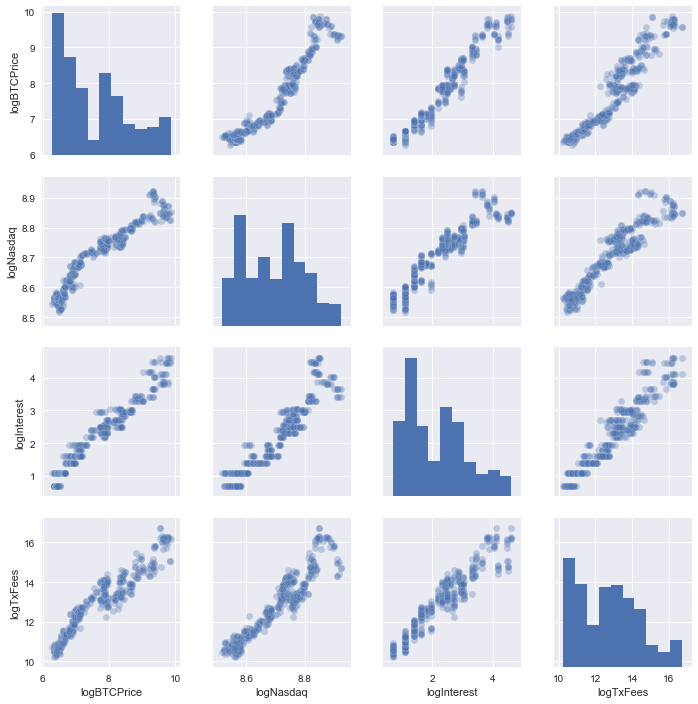

In [7]:
sns.set(style="darkgrid", color_codes=True)
sns.pairplot(df_all,plot_kws={'alpha':0.3})
# plt.title('Correlation by Feature',fontsize=14)
plt.savefig('charts/modelpairplot.png')

In [8]:
df = df_all
# STATSMODELS
# Feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('logBTCPrice ~ logInterest + logNasdaq + logTxFees', data=df, return_type="dataframe")

model = sm.OLS(y,X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     4673.
Date:                Fri, 02 Feb 2018   Prob (F-statistic):               0.00
Time:                        08:08:45   Log-Likelihood:                 127.36
No. Observations:                 466   AIC:                            -246.7
Df Residuals:                     462   BIC:                            -230.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -17.8351      2.316     -7.702      0.000     -22.385     -13.285
logInterest     0.5872      0.031     19.110      0.000       0.527       0.648
logNasdaq       2.6635      0.282      9.440      0.000       2.109       3.218
logTxFees       0.0804      0.020      3.973      0.000       0.041       0.120
==============================================================================
Omnibus:                        7.600   Durbin-Watson:                   0.202
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.162
Skew:                          -0.256   Prob(JB):                       0.0278
Kurtosis:                       2.674   Cond. No.                     4.26e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
# SKLEARN
lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X3 + X6 model
X = df[['logInterest','logNasdaq','logTxFees']]
# Choose the response variable(s)
y = df['logBTCPrice']

lr.fit(X,y)
# Print out the R^2 for the model against the full dataset
print(lr.score(X,y))
print(lr.intercept_)
print(lr.coef_)

0.9680954979875487
-17.83513731054112
[0.58722769 2.66346679 0.08040648]


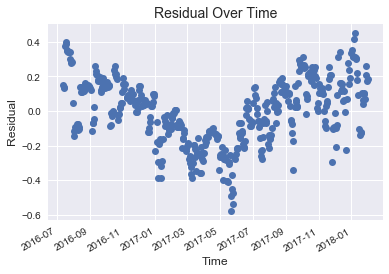

In [10]:
# Plotting residuals on a time series basis.
# Note that residuals are not random and will require further adjustments at a later time.  
fit.resid.plot(style='o');
plt.ylabel("Residual",fontsize=12)
plt.xlabel("Time",fontsize=12)
plt.title('Residual Over Time',fontsize=14)
plt.savefig('charts/residovertime.png')

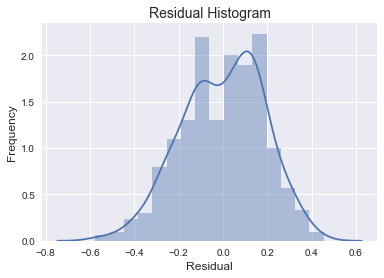

In [11]:
y_pred = lr.predict(X)

residuals = y - y_pred

sns.distplot(residuals);
plt.ylabel("Frequency",fontsize=12)
plt.xlabel("Residual",fontsize=12)
plt.title('Residual Histogram',fontsize=14)
plt.savefig('charts/residhist.png')

In [12]:
# TIME SERIES CROSS VALIDATION NOT INCLUDED IN THIS ANALYSIS (But may be incorporated later)
# The cross validation for a time series would be as follows:
# split = int(round(len(df) * 0.9,0))
# X_train, X_test, y_train, y_test = df.iloc[:split,1:], df.iloc[split:,1:],df.iloc[:split,0],df.iloc[split:,0]
# Due to project requirements, I am using the standard linear regression train-test split for this analysis.

In [13]:
from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size = 0.7)

# Fit the model against the training data
lr.fit(X_train, y_train)
# # Evaluate the model against the testing data
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.9690908557252359
0.9649717053813662


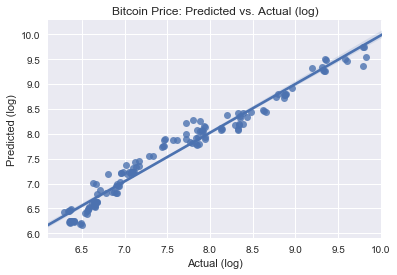

In [14]:
# sklearn prediction (logBTCPrice); seaborn
ax = sns.regplot(x=y_test,y=lr.predict(X_test), data=df)
ax.set(xlabel='Actual (log)', ylabel='Predicted (log)', title = 'Bitcoin Price: Predicted vs. Actual (log)')
plt.savefig('charts/logpredictedvsactual.png')

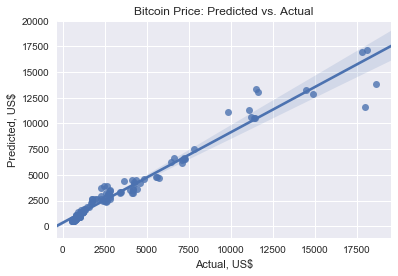

In [15]:
# sklearn prediction (BTCPrice); seaborn
ax = sns.regplot(x=np.exp(y_test),y=np.exp(lr.predict(X_test)), data=df)
ax.set(xlabel='Actual, US$', ylabel='Predicted, US$', title = 'Bitcoin Price: Predicted vs. Actual')
plt.savefig('charts/predictedvsactual.png')

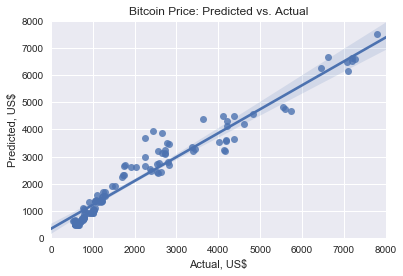

In [29]:
# limit x and y ticks to 8000 to see model prediction capability vs actual is near-aligned
ax = sns.regplot(x=np.exp(y_test),y=np.exp(lr.predict(X_test)), data=df)
ax.set(xlabel='Actual, US$', ylabel='Predicted, US$', title = 'Bitcoin Price: Predicted vs. Actual')
plt.xlim(0, 8000)
plt.ylim(0, 8000)
plt.savefig('charts/predictedvsactuallimits.png')

## Feature Analysis

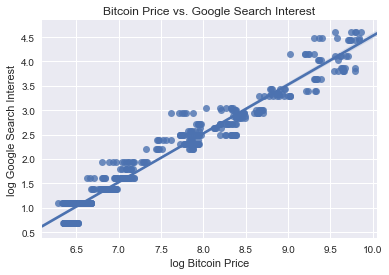

In [17]:
# GOOGLE SEARCH INTEREST
x = df['logBTCPrice']
y = df['logInterest']

ax = sns.regplot(x,y, data=df)
ax.set(xlabel='log Bitcoin Price', ylabel='log Google Search Interest', title = 'Bitcoin Price vs. Google Search Interest')
plt.savefig('charts/interestvsbtcprice.png')

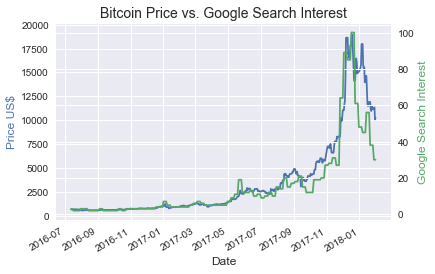

None


In [18]:
y1 = pd.Series(df_hist['BTCPrice'])
y2 = pd.Series(df_hist['Interest'])
x = pd.Series(df_hist.index.values)

fig, _ = plt.subplots()

ax = plt.gca()
ax2 = ax.twinx()

ax.plot(x,y1,'b')
ax2.plot(x,y2,'g')
ax.set_ylabel("Price US$",color='b',fontsize=12)
ax2.set_ylabel("Google Search Interest",color='g',fontsize=12)
ax.grid(True)
plt.title("Bitcoin Price vs. Google Search Interest", fontsize=14)
ax.set_xlabel('Date', fontsize=12)
fig.autofmt_xdate()

plt.savefig('charts/googlesearchinterest.png')
print(plt.show())

In [19]:
y, X = patsy.dmatrices('logBTCPrice ~ logInterest', data=df, return_type="dataframe")

# Create your model
model2 = sm.OLS(y,X)
# Fit your model to your training set
fit2 = model2.fit()
# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                 1.007e+04
Date:                Fri, 02 Feb 2018   Prob (F-statistic):          9.05e-317
Time:                        08:09:01   Log-Likelihood:                 52.241
No. Observations:                 466   AIC:                            -100.5
Df Residuals:                     464   BIC:                            -92.19
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.5686      0.022    249.303      0.000       5.525       5.613
logInterest     0.9556      0.010    100.356      0.000       0.937       0.974
==============================================================================
Omnibus:                        9.808   Durbin-Watson:                   0.275
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.110
Skew:                          -0.304   Prob(JB):                      0.00638
Kurtosis:                       3.388   Cond. No.                         6.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

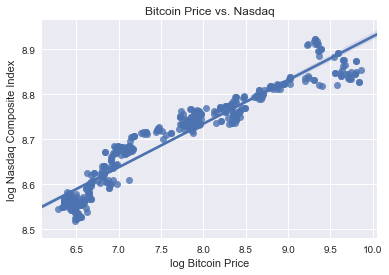

In [20]:
# FEATURE ANALYSIS: NASDAQ COMPOSITE INDEX
x = df['logBTCPrice']
y = df['logNasdaq']

ax = sns.regplot(x,y, data=df)
ax.set(xlabel='log Bitcoin Price', ylabel='log Nasdaq Composite Index', title = 'Bitcoin Price vs. Nasdaq')
plt.savefig('charts/nasdaqvsbtcprice.png')

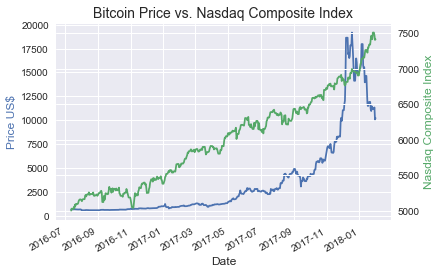

None


In [21]:
y1 = pd.Series(df_hist['BTCPrice'])
y2 = pd.Series(df_hist['Nasdaq'])
x = pd.Series(df_hist.index.values)

fig, _ = plt.subplots()

ax = plt.gca()
ax2 = ax.twinx()

ax.plot(x,y1,'b')
ax2.plot(x,y2,'g')
ax.set_ylabel("Price US$",color='b',fontsize=12)
ax2.set_ylabel("Nasdaq Composite Index",color='g',fontsize=12)
# ax.grid(True)
plt.title("Bitcoin Price vs. Nasdaq Composite Index", fontsize=14)
ax.set_xlabel('Date', fontsize=12)
fig.autofmt_xdate()
# ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))

plt.savefig('charts/nasdaq.png')
print(plt.show())

In [22]:
y, X = patsy.dmatrices('logBTCPrice ~ logNasdaq', data=df, return_type="dataframe")

# Create your model
model3 = sm.OLS(y,X)
# Fit your model to your training set
fit3 = model3.fit()
# Print summary statistics of the model's performance
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     5202.
Date:                Fri, 02 Feb 2018   Prob (F-statistic):          2.88e-254
Time:                        08:09:04   Log-Likelihood:                -92.275
No. Observations:                 466   AIC:                             188.6
Df Residuals:                     464   BIC:                             196.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -74.8922      1.143    -65.498      0.000     -77.139     -72.645
logNasdaq      9.4862      0.132     72.125      0.000       9.228       9.745
==============================================================================
Omnibus:                       23.825   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.046
Skew:                           0.554   Prob(JB):                     2.21e-06
Kurtosis:                       3.335   Cond. No.                         736.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

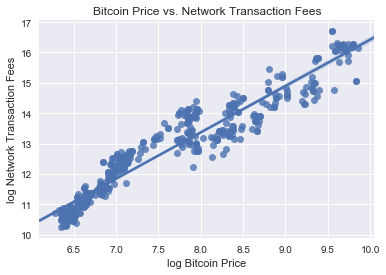

In [23]:
# FEATURE ANALYSIS: TRANSACTION FEES
x = df['logBTCPrice']
y = df['logTxFees']

ax = sns.regplot(x,y, data=df)
ax.set(xlabel='log Bitcoin Price', ylabel='log Network Transaction Fees', title = 'Bitcoin Price vs. Network Transaction Fees')
plt.savefig('charts/txfeesvsbtcprice.png')

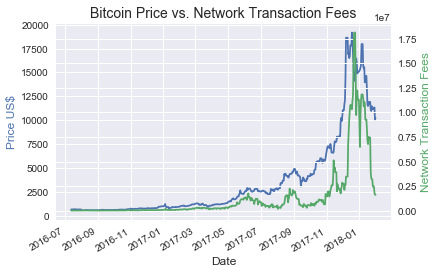

None


In [24]:
y1 = pd.Series(df_hist['BTCPrice'])
y2 = pd.Series(df_hist['TxFees'])
x = pd.Series(df_hist.index.values)

fig, _ = plt.subplots()

ax = plt.gca()
ax2 = ax.twinx()

ax.plot(x,y1,'b')
ax2.plot(x,y2,'g')
ax.set_ylabel("Price US$",color='b',fontsize=12)
ax2.set_ylabel("Network Transaction Fees",color='g',fontsize=12)
# ax.grid(True)
plt.title("Bitcoin Price vs. Network Transaction Fees", fontsize=14)
ax.set_xlabel('Date', fontsize=12)
fig.autofmt_xdate()
# ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))

plt.savefig('charts/txfees.png')
print(plt.show())

In [25]:
y, X = patsy.dmatrices('logBTCPrice ~ logTxFees', data=df, return_type="dataframe")

# Create your model
model4 = sm.OLS(y,X)
# Fit your model to your training set
fit4 = model4.fit()
# Print summary statistics of the model's performance
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     5213.
Date:                Fri, 02 Feb 2018   Prob (F-statistic):          1.86e-254
Time:                        08:09:07   Log-Likelihood:                -91.837
No. Observations:                 466   AIC:                             187.7
Df Residuals:                     464   BIC:                             196.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0698      0.107     -0.654      0.513      -0.280       0.140
logTxFees      0.6011      0.008     72.199      0.000       0.585       0.617
==============================================================================
Omnibus:                        3.705   Durbin-Watson:                   0.214
Prob(Omnibus):                  0.157   Jarque-Bera (JB):                3.662
Skew:                           0.181   Prob(JB):                        0.160
Kurtosis:                       2.759   Cond. No.                         101.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""